In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

In [2]:
from pathlib import Path
import os
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
koniq10k_path = Path("/home/mrpaw/Documents/mag_databases/KonIQ-10k")
koniq10k_images_path = koniq10k_path / "koniq10k_1024x768/1024x768"
koniq10k_scores_path = koniq10k_path / "koniq10k_scores_and_distributions/koniq10k_scores_and_distributions.csv"

In [5]:
scores = pd.read_csv(koniq10k_scores_path)
scores

,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,MOS_zscore
0,10004473376.jpg,0,0,25,73,7,105,3.828571,0.527278,77.383621
1,10007357496.jpg,0,3,45,47,1,96,3.479167,0.580003,68.728571
2,10007903636.jpg,1,0,20,73,2,96,3.781250,0.527220,78.628571
3,10009096245.jpg,0,0,21,75,13,109,3.926606,0.556218,77.243750
4,100117038.jpg,0,1,21,72,6,100,3.830000,0.532860,75.112500
...,...,...,...,...,...,...,...,...,...,...
10068,9984535544.jpg,0,0,46,55,3,104,3.586538,0.550562,70.020089
10069,9991658304.jpg,0,1,12,85,6,104,3.923077,0.455651,79.337838
10070,9991999836.jpg,0,0,15,79,7,101,3.920792,0.462237,78.092437
10071,9995874256.jpg,0,3,53,51,1,108,3.462963,0.570717,68.095133


In [12]:
print(scores["MOS"].values)
print(scores["MOS"].values[4])

[3.82857143 3.47916667 3.78125    ... 3.92079208 3.46296296 3.41747573]
3.83


In [23]:
from torch.utils.data import Dataset
import torch;
from typing import Tuple
from PIL import Image
import matplotlib.pyplot as plt

class Koniq10kData(Dataset):
  def __init__(self, path:Path, train:bool, transform:torch.nn.Module = None, testSize = 0.2, normalize = True) -> None:
    super().__init__()
    self.train = train
    self.path = path
    self.dataPath = path / "koniq10k_scores_and_distributions/koniq10k_scores_and_distributions.csv"
    self.imagesPath = path / "koniq10k_1024x768/1024x768"
    self.normalize = True

    scores = pd.read_csv(self.dataPath)
    self.mos = scores["MOS"].values
    self.images = scores["image_name"].values

    length = len(self.mos)

    #skiping first 7 indexes because those were to train participans
    self.indexes = np.arange(start=0, stop=length) 


    i_train, i_test = train_test_split(self.indexes, test_size=testSize, random_state=21, shuffle=True)

    self.indexes = i_train if train else i_test
    
    self.transform = transform

  def __len__(self):
    return len(self.indexes)  

  def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
    i = self.indexes[index]
    img_path = self.imagesPath / self.images[i]
    mos = self.mos[i]

    print(img_path)
    img = Image.open(img_path)

    if(self.transform != None):
      img = self.transform(img)

    if(self.normalize):
      mos = mos / 5.0

    mos = torch.tensor(mos)

    return (img, mos)

In [24]:
trainData = Koniq10kData(koniq10k_path, True)
testData = Koniq10kData(koniq10k_path, False)

/home/mrpaw/Documents/mag_databases/KonIQ-10k/koniq10k_1024x768/1024x768/9034047597.jpg
<class 'torch.Tensor'>
tensor(0.6846, dtype=torch.float64)


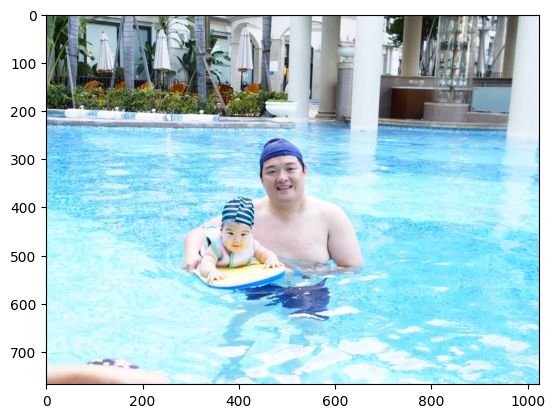

In [25]:
img, mos = trainData[20]
print(type(mos))
print(mos)
plt.imshow(img)